In [1]:
from utils_prediction.database import (gbq_connect, gbq_query)
from utils_prediction.dataloader.mimic4 import dataloader
from utils_prediction.preprocessor import (fill_missing,discretizer,binary_discretizer,one_hot_encoder,prune_features)

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.metrics import roc_auc_score, plot_confusion_matrix

import os
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

#### 1. Get example features from GBQ and save to disk

In [2]:
## Establish connection with GBQ
c = gbq_connect(
    service_account_json_path = '/hpf/projects/lsung/creds/gbq/mimic.json', # change to your service account auth
    project_id = 'mimic-iv-ches'
    )

## Grab example data
df = gbq_query(c, """
    select * from `mimic-iv-ches.demo.mimic4_slice`
    """, verbose = False)

## Save to disk
path = 'data/analysis_id=demo'

if not os.path.exists(path): os.makedirs(path)

pq.write_table(
    pa.Table.from_pandas(df),
    f"{path}/features.parquet"
    )

Google Big Query Connection Established


### 2. Dataloader

#### 2.1 Load Features
- dataloader class creates datasets from extracted features, performs splitting, and saves the split datasets as separate parquet files. 

In [3]:
data = dataloader(
    analysis_id = 'demo',
    features_fpath = 'data'
    ).load_features()

In [4]:
#data.features.head(3)

#### 2.2 Split Features
- Splits features into datasets (train, validation, test) based on p_splits (default: 0.7, 0.15, 0.15)
- After splitting, dataloader class will have new attributes: X_train, X_val, X_test, y_train, y_val, y_test
- features attribute will be removed post splitting by default (set remove_original to False if want to keep)

In [5]:
data = data.split()

In [6]:
print(f"number of training samples: {len(data.y_train)}")
print(f"number of validation samples: {len(data.y_val)}")
print(f"number of test samples: {len(data.y_test)}")

number of training samples: 1400
number of validation samples: 300
number of test samples: 300


### 3. Pipeline with Preprocessing and ML
- Example of how preprocessors can be used with sklearn's Pipeline

#### 3.1 Construct pipeline

In [7]:
## Pipeline
pipe = Pipeline([
    ('fill missings',fill_missing(config={'count':0,'marital_status':'None'})),
    ('prune features',prune_features(special_cols={'count':0})),
    ('discretize counts', binary_discretizer(feature_tags_to_include= ['count'])),
    ('discretize measurements', discretizer(feature_tags_to_include = ['measurement'])),
    ('one hot encode', one_hot_encoder(feature_tags_to_exclude = ['count'])),
    ('prediction model', rf(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state = 44))
    ])

#### 3.2 Fit on train, test on validation set

AUROC: 0.83 



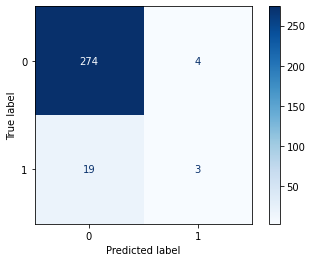

In [8]:
pipe.fit(data.X_train, data.y_train)

# Make prediction using pipeline
y_score = pipe.predict_proba(data.X_val)

## Results
print('AUROC:',round(roc_auc_score(data.y_val, y_score[:,1]),2),'\n')
plot_confusion_matrix(pipe, data.X_val, data.y_val, cmap=plt.cm.Blues)
plt.show()